In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
number_of_files = 66 + 16

# 66 betrouwbare data, daarna veel ethanoldamp in de lucht (hoe kan dat nou?) 

data = []
data_T = [[], [], [], [], [], []]

for i in range(0, number_of_files+1):
    data.append([])
    t = []
    A0 = []
    A1 = []
    A2 = []
    # open_file = open(f"C:/Users/Michiel Erkamp/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    open_file = open(f"C:/Users/Michiel/Desktop/Bachelor-project/data/data-{i}.csv", 'r')
    for line in open_file:
        data_opgeknipt = line.split(',')
        try:
            data_opgeknipt = line.split(',')
            t.append(float(data_opgeknipt[0]))
            A0.append(float(data_opgeknipt[1]))
            A1.append(float(data_opgeknipt[2])) 
            A2.append(float(data_opgeknipt[3]))
        except:
            if data_opgeknipt[0] == "height of setup:":
                height = round(float(data_opgeknipt[1]) - (13.1 + 42.4 + 40.29*0), 2)
    open_file.close()

    A_avg = np.mean(np.array([A0, A1, A2]), axis=0)

    data[i-0].append([height] * len(t))
    data[i-0].append(t)
    data[i-0].append(A0)
    data[i-0].append(A1)
    data[i-0].append(A2)
    data[i-0].append(A_avg)

    data_T[0].append([height] * len(t))
    data_T[1].append(t)
    data_T[2].append(A0)
    data_T[3].append(A1)
    data_T[4].append(A2)
    data_T[5].append(A_avg)


data_all = [[], [], [], [], [], []]
for i in range(len(data_all)):
    for row in data_T[i]:
        data_all[i].extend(row)

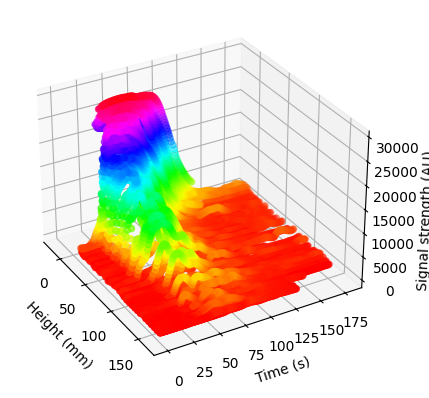

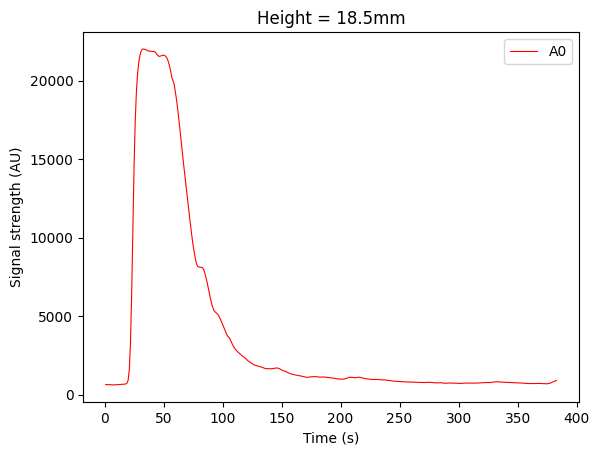

<Figure size 640x480 with 0 Axes>

In [19]:
indices = np.where(np.array(data_all[1]) < 180)[0]
# print(indices)

x = np.array(data_all[0])[indices]
y = np.array(data_all[1])[indices]
z = np.array(data_all[2])[indices]

ax = plt.axes(projection='3d')
# ax.plot_trisurf(x,y,z, cmap='hsv')
ax.scatter3D(x,y,z, '.', c=z, cmap='hsv') # viridis
ax.view_init(elev=30, azim=-30)
ax.set_xlabel(r'Height (mm)')
ax.set_ylabel(r'Time (s)')
ax.set_zlabel(r'Signal strength (AU)')
plt.savefig('exp2_alldata.png')
plt.show()
plt.clf()

plt.plot(data[5][1], data[5][2], color="red", linewidth=0.8, label="A0")

plt.title(f"Height = {data[5][0][0]}mm")
plt.legend(loc='best')
plt.xlabel("Time (s)")
plt.ylabel("Signal strength (AU)")
plt.savefig('exp2_rawdata.png')
plt.show()
plt.clf()

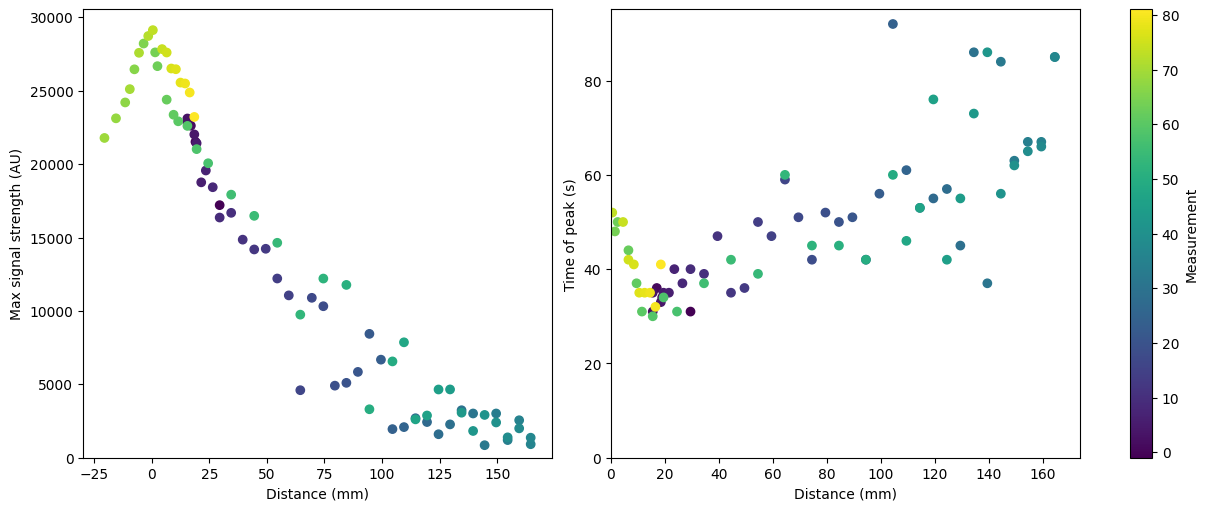

<Figure size 640x480 with 0 Axes>

In [20]:
height_top = []
time_top = []
signal_top = []


for measurement in data:
    index = np.where(measurement[2] == np.max(measurement[2]))[0][0]
    height_top.append(measurement[0][index])
    time_top.append(measurement[1][index])
    signal_top.append(measurement[2][index])

# Create side-by-side subplots with equal width
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot on the left
sc = axes[0].scatter(height_top, signal_top, c=range(-1, number_of_files), cmap='viridis')
# axes[0].plot([0,150], [1000,1000])
# axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].set_xlabel("Distance (mm)")
axes[0].set_ylabel("Max signal strength (AU)")

# Plot on the right
axes[1].scatter(height_top, time_top, c=range(-1, number_of_files), cmap='viridis')
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)
axes[1].set_xlabel("Distance (mm)")
axes[1].set_ylabel("Time of peak (s)")

# Add a shared colorbar on the right side
cbar = fig.colorbar(sc, ax=axes, location='right', label='Measurement')

plt.show()
plt.clf()

Finding location of line

-0.0024543947498650714


c:\Users\Michiel\anaconda3\envs\prototyping\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


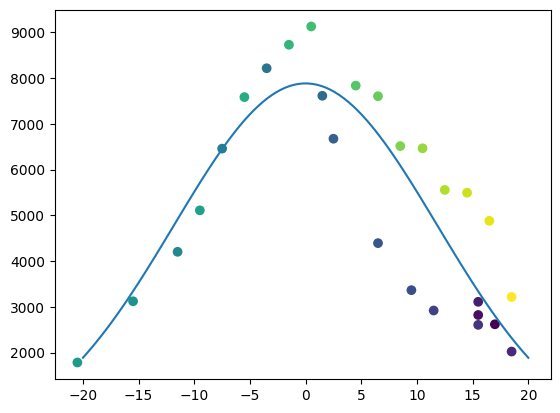

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 27
    # variables        = 3
    chi-square         = 32383989.6
    reduced chi-square = 1349332.90
    Akaike info crit   = 383.928122
    Bayesian info crit = 387.815632
    R-squared          = 0.75521206
[[Variables]]
    amplitude:  233647.603 +/- 14542.5194 (6.22%) (init = 11000)
    center:    -0.00245439 +/- 0.79519784 (32398.94%) (init = 0)
    sigma:      11.8250682 +/- 0.89553368 (7.57%) (init = 20)
    fwhm:       27.8459071 +/- 2.10882061 (7.57%) == '2.3548200*sigma'
    height:     7882.56867 +/- 410.879392 (5.21%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.7311
    C(amplitude, center) = -0.4824
    C(center, sigma)     = -0.3974


<Figure size 640x480 with 0 Axes>

In [21]:
from lmfit import models

index_x_min = np.where(height_top == np.min(height_top))[0][0]

index_peak = np.where(np.array(signal_top) >= signal_top[index_x_min])[0]

x = np.array(height_top)[index_peak]
y = np.array(signal_top)[index_peak] - 20000

model = models.GaussianModel()

result = model.fit(y, x=x, weights=1, amplitude=11000, center=0, sigma=20)

amplitude = result.params["amplitude"].value
center = result.params["center"].value
sigma = result.params["sigma"].value

print(center)

plt.scatter(x, y, c=range(len(x)))

x = np.linspace(-20,20,100)
y = amplitude / (np.sqrt(2.0 * np.pi) * sigma) * np.exp(-np.power((x - center) / sigma, 2.0) / 2)

plt.plot(x,y)
plt.show()
plt.clf()

print(result.fit_report())

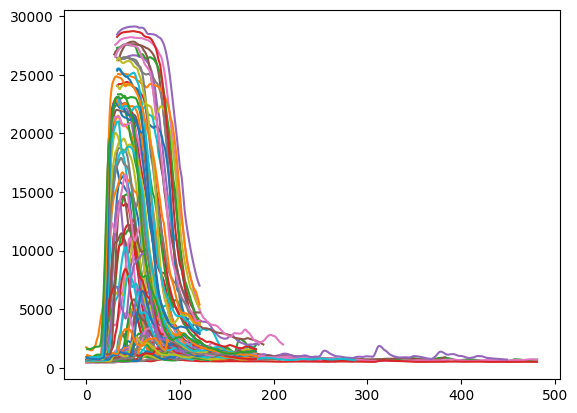

<Figure size 640x480 with 0 Axes>

In [24]:
for i in range(len(data)):
    plt.plot(np.array(data[i][1]), data[i][2], label=f"{i}")

# plt.legend(loc="best")

plt.show()
plt.clf()

4774.504678978436


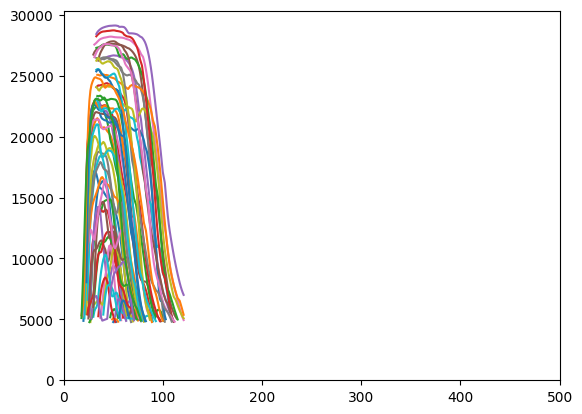

<Figure size 640x480 with 0 Axes>

In [23]:
baselines = []

for i in range(len(data)):
    baseline_i = np.mean(data[i][2][-30:])
    baselines.append(baseline_i)

baseline = np.mean(baselines)
deviation = np.std(baselines)

threshold = baseline + deviation

print(threshold)


for i in range(len(data)):
    index = np.where(data[i][2] > threshold)[0]
    plt.plot(np.array(data[i][1])[index], np.array(data[i][2])[index])

plt.xlim(0,500)
plt.ylim(bottom=0)
plt.show()
plt.clf()